# ltu-ili evidence estimation
This is a tutorial for using ltu-ili evidence networks in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [4]:
# Imports
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PlotSinglePosterior

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
 

Device: cuda:0


### Notes OF Things changed

Making more inputs tensors on the right devices.   
Making EnsemblePotential inherit the device of NeuralPosteriorEnsemble in sbi

## Theory

Implicit likelihood inference as implemented throughout most of ltu-ili is intended for parameter inference, i.e. trying to constrain some parameters $\theta$ from some observational data $x_o$ given a data-generating model $\mathcal{M}$. In parameter inference, we generate data-parameter pairs from this fixed model in order to train neural networks, i.e. $x\sim \mathcal{M}(\theta)$. The end product of this training is samples from the posterior,
$$ \theta \sim p(\theta|x_o, \mathcal{M}) $$

However, a similarly important, but separate, task in Bayesian inference is model comparison. In model comparison, we are given an observed datapoint $x_o$ and then asked to determine whether it is more likely that this data was generated from one of two models $\mathcal{M}_1$ or $\mathcal{M}_2$. In this case, we are not interested in the posterior distribution of parameters, but rather the evidence of the model given the data,
$$ p(\mathcal{M}_i|x_o) = \frac{p(x_o|\mathcal{M}_i)p(\mathcal{M}_i)}{p(x_o)} $$
This quantity can be interpreted as our belief in model $\mathcal{M}_i$ given the data $x_o$. Here, $p(x_o)$ is the marginal likelihood of the data (equal for all $i$) and $p(\mathcal{M}_i)$ is the prior probability of the model (also often equal for all $i$). The key quantity in the above expression is the data likelihood under a given model $p(x_o|\mathcal{M}_i)$, which can be further decomposed as a marginalization of the parameter inference likelihood over the parameter prior,
$$ z_i = p(x_o|\mathcal{M}_i) = \int p(x_o|\theta, \mathcal{M}_i)p(\theta|\mathcal{M}_i)d\theta $$
Specifying a model $\mathcal{M}_i$ then requires a choice of the data likelihood $p(x_o|\theta, \mathcal{M}_i)$ and the parameter prior $p(\theta|\mathcal{M}_i)$, the former of which we can estimate from samples $x\sim \mathcal{M}_i(\theta)$ using ltu-ili.

The primary utility of measuring the evidence is in doing Bayesian model comparison. Effectively, given two models $\mathcal{M}_1$ and $\mathcal{M}_2$, we can compute the evidence of each model given the data and then compare the two via the Bayes Ratio,
$$ K = \frac{p(\mathcal{M}_1|x_o)}{p(\mathcal{M}_2|x_o)} = \frac{p(x_o|\mathcal{M}_1)}{p(x_o|\mathcal{M}_2)}\frac{p(\mathcal{M}_1)}{p(\mathcal{M}_2)} $$
Note, how the marginal likelihood $p(x_o)$ cancels out. This Bayes Ratio has a clear interpretation: if $K>1$, then the data is more likely to have been generated from model $\mathcal{M}_1$ than $\mathcal{M}_2$, and vice versa. For heuristic measures of the strength of this preference, see [Jeffrey's scale of interpretation for $K$](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation).

## Description

In this tutorial, our target is to measure the Bayes Factor $K$ to express the preference of the following two models when observed data $x_o \in \mathbb{R}^k$:
1. $\mathcal{M}_1$ : $x\sim \mathcal{N}\left(\mu,\mathbb{I}\right)$ with prior $p(\mu|\mathcal{M}_1) = \mathcal{N}\left(\mu_1,\mathbb{I}\right)$ where $\mu_1 = 0$
2. $\mathcal{M}_2$ : $x\sim \mathcal{N}\left(\mu,\mathbb{I}\right)$ with prior $p(\mu|\mathcal{M}_2) = \mathcal{N}\left(\mu_2,\mathbb{I}\right)$ where $\mu_2 = 1$

As you can see, both models generate data $x$ from a multivariate normal with mean $\mu$. The $\mu$'s for each model serve as our model parameters $\theta$. The difference between the two models is their prior on $\mu$.

Both models are extremely simple, and their posteriors and evidences can be calculated analytically.
$$ p(\mu|x, \mathcal{M}_i) = \mathcal{N}\left(\mu;\frac{x+\mu_i}{2}, \frac{1}{2}\mathbb{I}\right)$$
$$ p(x|\mathcal{M}_i) = \mathcal{N}\left(x;\mu_i,2\mathbb{I}\right) $$

We will then try to compute the Bayes Factor $K$ of this simple model and compare it to the analytic result using two methods:
1. Using the Learnt Harmonic Mean Estimator from [McEwen et al. (2021)](https://arxiv.org/abs/2111.12720)
2. Using the Evidence Network from [Jeffrey \& Wandelt (2023)](https://arxiv.org/abs/2305.11241)


## Specify models $\mathcal{M}_1$ and $\mathcal{M}_2$

In [5]:
from scipy.stats import multivariate_normal as mvnorm

Ndim = 5               # number of dimensions
mu1 = 0*np.ones(Ndim)  # mean of mu prior (Model 1)
mu2 = 1*np.ones(Ndim)  # mean of mu prior (Model 2)

# Specify model generating distributions
prior1 = mvnorm(mean=np.ones(Ndim)*mu1, cov=np.eye(Ndim))
prior2 = mvnorm(mean=np.ones(Ndim)*mu2, cov=np.eye(Ndim))

def gen_data(n_samples, theta):
    dist = mvnorm(mean=np.zeros(Ndim), cov=np.eye(Ndim))
    return theta + dist.rvs(n_samples)

# Specify analytic posterior and evidence
def analytic_ln_posterior(mu, x, mui):
    _mean = (x+mui)/2
    _cov = np.eye(Ndim)/2
    return mvnorm(mean=_mean, cov=_cov).logpdf(mu)

def analytic_evidence(x, mui):
    _mean = mui
    _cov = np.eye(Ndim)*2
    return mvnorm(mean=_mean, cov=_cov).pdf(x)

In [7]:
# Generate data from each model
n_samples = 10_000

# Model 1
theta1 = prior1.rvs(n_samples)
x1 = gen_data(n_samples, theta1)
K1 = analytic_evidence(x1, mu2) / analytic_evidence(x1, mu1)

# Model 2
theta2 = prior2.rvs(n_samples)
x2 = gen_data(n_samples, theta2)
K2 = analytic_evidence(x2, mu2) / analytic_evidence(x2, mu1)

# Observed data (from Model 1)
theta_obs = prior2.rvs(1)
x_obs = gen_data(1, theta_obs)
z1_obs = analytic_evidence(x_obs, mu1)
z2_obs = analytic_evidence(x_obs, mu2)
K_obs = z1_obs / z2_obs

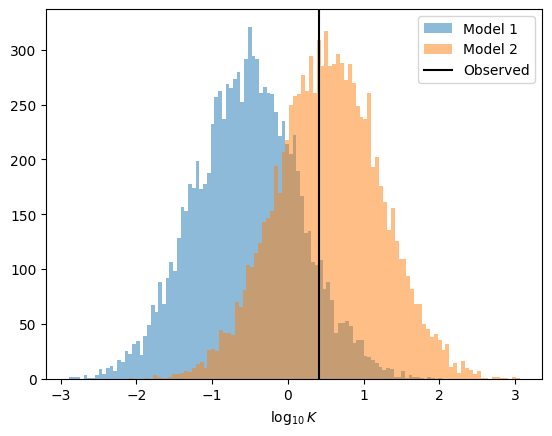

In [4]:
plt.hist(np.log10(K1), bins=100, alpha=0.5, label='Model 1')
plt.hist(np.log10(K2), bins=100, alpha=0.5, label='Model 2')
plt.axvline(np.log10(K_obs), color='k', label='Observed')
plt.xlabel(r'$\log_{10} K$')
plt.legend();

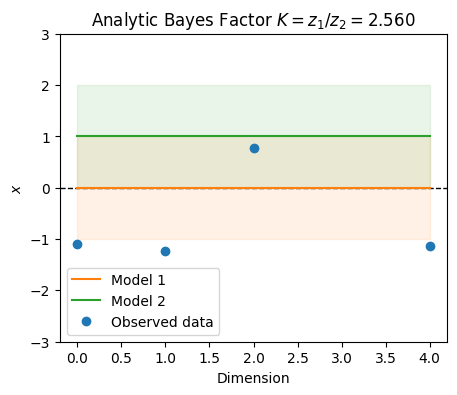

In [5]:
# Plot the observed data
f, ax = plt.subplots(1, 1, figsize=(5, 4))
_x = np.arange(Ndim)
ax.axhline(0, color='black', lw=1, ls='--')

ax.plot(_x, mu1, '-', c='C1', label='Model 1')
ax.fill_between(_x, mu1-1, mu1+1, color='C1', alpha=0.1)

ax.plot(_x, mu2, '-', c='C2', label='Model 2')
ax.fill_between(_x, mu2-1, mu2+1, color='C2', alpha=0.1)

ax.plot(_x, x_obs, 'o', label='Observed data')

ax.set_title(f'Analytic Bayes Factor $K = z_1/z_2 = {K_obs:.3f}$')
ax.set_ylim(-3, 3)
ax.set(xlabel='Dimension', ylabel='$x$')
ax.legend()

In [8]:
# Split into train/test and build loaders
test_split = 0.1

# Model 1
mask1 = np.random.rand(n_samples) > test_split
x1_train, x1_test = x1[mask1], x1[~mask1]
theta1_train, theta1_test = theta1[mask1], theta1[~mask1]
K1_train, K1_test = K1[mask1], K1[~mask1]

# Model 2
mask2 = np.random.rand(n_samples) > test_split
x2_train, x2_test = x2[mask2], x2[~mask2]
theta2_train, theta2_test = theta2[mask2], theta2[~mask2]
K2_train, K2_test = K2[mask2], K2[~mask2]

# Build loaders
loader1_train = NumpyLoader(x1_train, theta1_train)
loader1_test = NumpyLoader(x1_test, theta1_test)
loader2_train = NumpyLoader(x2_train, theta2_train)
loader2_test = NumpyLoader(x2_test, theta2_test)

## Harmonic Estimator (Evidence)

In [31]:
# Training scripts to train NPE/NLE with LtU-ILI
def train_nde(loader, prior_mu, engine='NLE')
    # define a prior
    prior_mu = torch.tensor(prior_mu, dtype=torch.float32)
    scale  = torch.tensor(1*np.ones(Ndim), dtype=torch.float32)

    print(prior_mu.size())
    print(scale.size())

    prior_mu = prior_mu.to(device)
    scale = scale.to(device)
    
    prior = ili.utils.IndependentNormal(
        loc=prior_mu,
        scale=scale,
        device=device
    )
    
    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_sbi(
            engine=engine, model='mdn', hidden_features=8, num_components=2),
    ]
    # define training arguments
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 5e-4
    }
    # initialize the trainer
    runner = InferenceRunner.load(
        backend='sbi',
        engine=engine,
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args,
    )
    # train the model
    posterior_ensemble, summaries = runner(loader=loader)
    return posterior_ensemble, summaries

In [34]:
# Train Neural Likelihood Estimation
mu1 = 0*np.ones(6)

nle1, summ_nle1 = train_nde(loader1_train, mu1, 'NLE')
nle2, summ_nle2 = train_nde(loader2_train, mu2, 'NLE')

# Train Neural Posterior Estimation
npe1, summ_npe1 = train_nde(loader1_train, mu1, 'NPE')
npe2, summ_npe2 = train_nde(loader2_train, mu2, 'NPE')

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


torch.Size([6])
torch.Size([6])
 Training neural network. Epochs trained: 150

INFO:root:It took 45.37134408950806 seconds to train models.
INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Neural network successfully converged after 151 epochs.torch.Size([5])
torch.Size([5])
 Training neural network. Epochs trained: 142

INFO:root:It took 42.17394495010376 seconds to train models.


 Neural network successfully converged after 143 epochs.

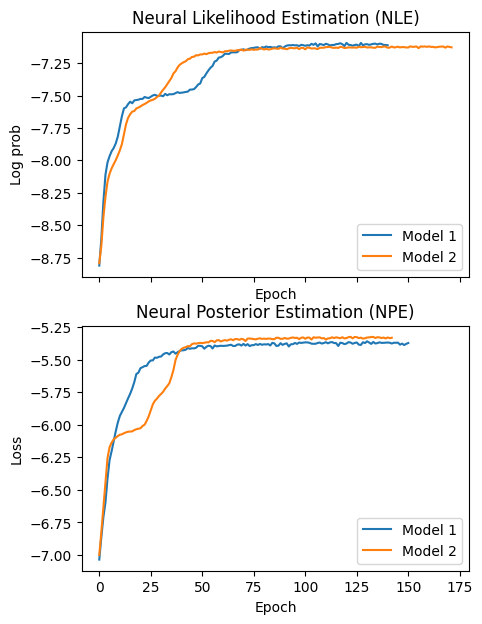

In [ ]:

mu1 = 0*np.ones(6)

nle1, summ_nle1 = train_nde(loader1_train, mu1, 'NLE')
nle2, summ_nle2 = train_nde(loader2_train, mu2, 'NLE')

# Train Neural Posterior Estimation
npe1, summ_npe1 = train_nde(loader1_train, mu1, 'NPE')
npe2, summ_npe2 = train_nde(loader2_train, mu2, 'NPE')# Plot loss for both models
f, axs = plt.subplots(2, 1, figsize=(5, 7), sharex=True)

ax = axs[0]
ax.plot(summ_nle1[0]['validation_log_probs'], label='Model 1')
ax.plot(summ_nle2[0]['validation_log_probs'], label='Model 2')
ax.set_title('Neural Likelihood Estimation (NLE)')
ax.set(xlabel='Epoch', ylabel='Log prob')
ax.legend()

ax = axs[1]
ax.plot(summ_npe1[0]['validation_log_probs'], label='Model 1')
ax.plot(summ_npe2[0]['validation_log_probs'], label='Model 2')
ax.set_title('Neural Posterior Estimation (NPE)')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

Had to make some changes here - needed to put observations on the correct device. And needed to move samples back to cpu to flatten.

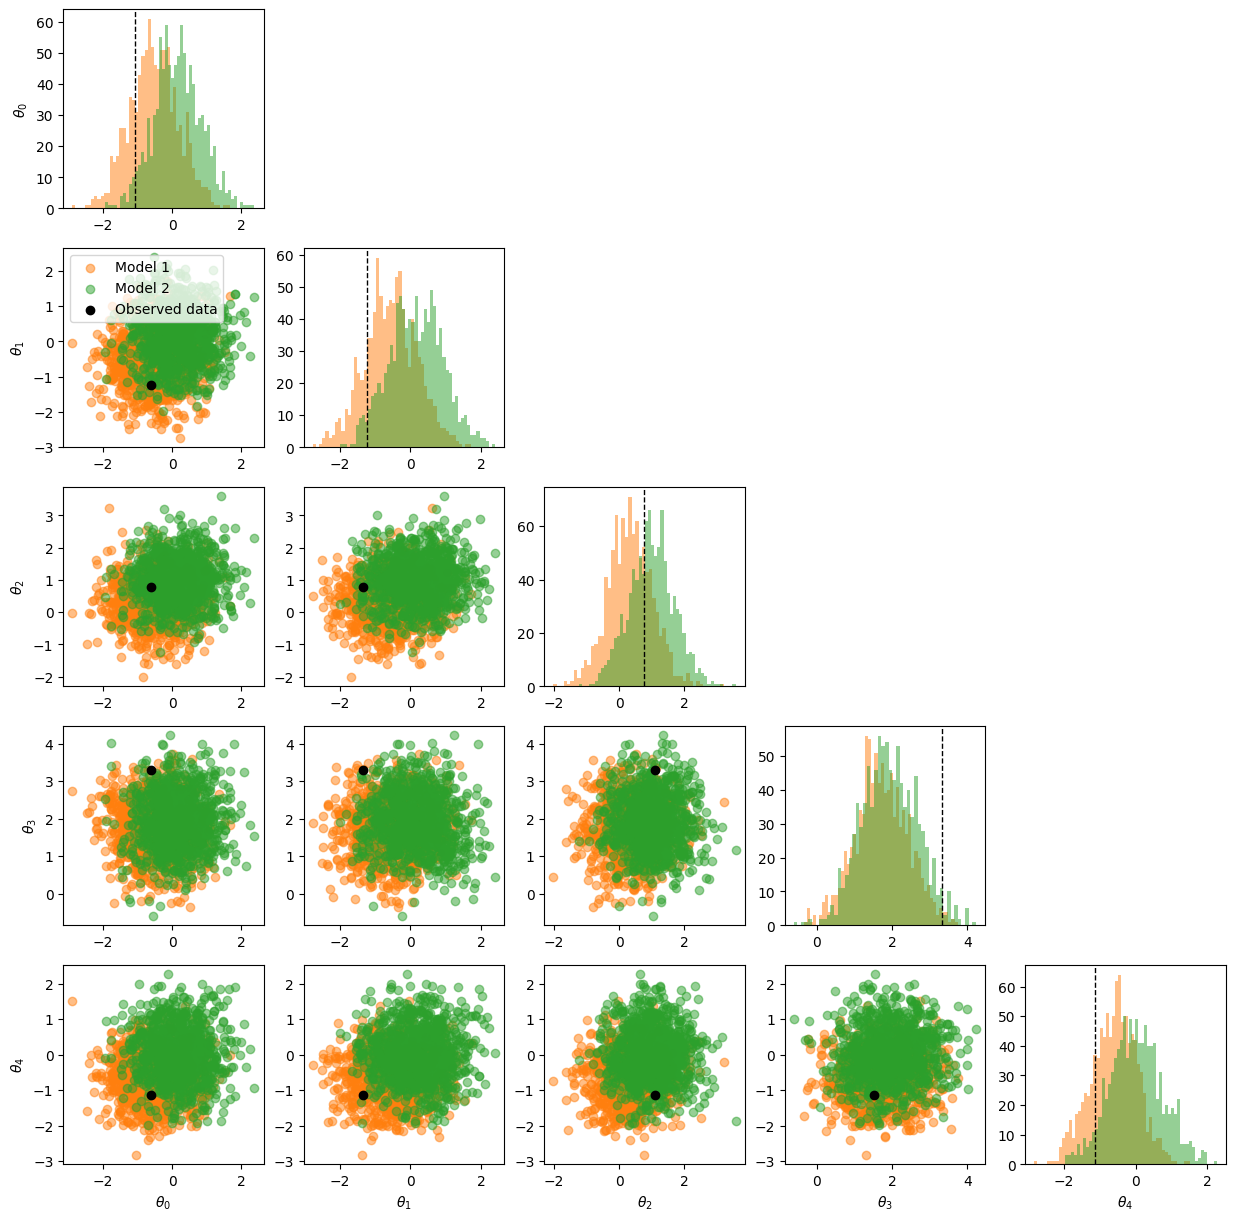

In [36]:
# Convert x_obs to a torch tensor if it isn't already
x_obs_tensor = torch.tensor(x_obs, dtype=torch.float32)

# Move x_obs to the same device as the trained models
x_obs_tensor = x_obs_tensor.to(device)

# Plot the observed posterior for both models
samples1 = npe1.sample((1000,), x=x_obs_tensor, show_progress_bars=False)
samples2 = npe2.sample((1000,), x=x_obs_tensor, show_progress_bars=False)

f, axs = plt.subplots(Ndim, Ndim, figsize=(15, 15))
for i in range(Ndim):
    for j in range(Ndim):
        if i == j:
            axs[i, j].hist(samples1[:, i].cpu().flatten(), bins=50, alpha=0.5, color='C1', label='Model 1')
            axs[i, j].hist(samples2[:, i].cpu().flatten(), bins=50, alpha=0.5, color='C2', label='Model 2')
            axs[i, j].axvline(x_obs[i], color='black', lw=1, ls='--')
        elif i < j:
            axs[i,j].axis('off')
            continue
        else:
            axs[i, j].scatter(samples1[:, j].cpu().flatten(), samples1[:, i].cpu().flatten(), alpha=0.5, color='C1', label='Model 1')
            axs[i, j].scatter(samples2[:, j].cpu().flatten(), samples2[:, i].cpu().flatten(), alpha=0.5, color='C2', label='Model 2')
            axs[i, j].scatter(theta_obs[j], x_obs[i], color='black', label='Observed data')
        
        if i == Ndim-1:
            axs[i, j].set(xlabel=f'$\\theta_{j}$')
        if j == 0:
            axs[i, j].set(ylabel=f'$\\theta_{i}$')

axs[1, 0].legend();


In [37]:
from ili.evidence import HarmonicEvidence


print(npe1.ensure_same_device(npe1.posteriors))
print(nle1.ensure_same_device(nle1.posteriors))
print(x_obs_tensor.device)
print(npe1._device)
print(nle1._device)
print(npe1.prior.device)
print(nle1.prior.device)
print(nle1.prior)


estimator1 = HarmonicEvidence()

estimator1.from_nde(
    npe1, nle1, x=x_obs_tensor,
    shape=(10_000,),
    show_progress_bars=False
)

estimator2 = HarmonicEvidence()
estimator2.from_nde(
    npe2, nle2, x=x_obs_tensor,
    shape=(10_000,),
    show_progress_bars=False
)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
IndependentNormal(Normal(loc: torch.Size([6]), scale: torch.Size([6])), 1)


ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([10000, 5]) vs torch.Size([6]).

In [14]:
z1_obs = analytic_evidence(x_obs, mu1)
z2_obs = analytic_evidence(x_obs, mu2)
K_obs = z1_obs / z2_obs
K_est, stdK_est = estimator1.get_bayes_factor(estimator2)

print(f"Analytic Bayes Factor: {K_obs:.5f}")
print(f"Predicted Bayes Factor: {K_est:.5f} +/- {stdK_est:.5f}")

Analytic Bayes Factor: 2.56034
Predicted Bayes Factor: 1.78956 +/- 0.03193


In [16]:
N_test = 10  # takes a while, so subsample
x_test = np.concatenate([x1_test[:N_test], x2_test[:N_test]], axis=0)
K_test = np.concatenate([K1_test[:N_test], K2_test[:N_test]], axis=0)
lnK_test = np.log(K_test)

lnK_pred = []
for xi in x_test:
    xi = torch.tensor(xi, dtype=torch.float32, device=device)
    estimator1 = HarmonicEvidence()
    estimator1.from_nde(
        npe1, nle1, x=xi,
        shape=(10_000,),
        show_progress_bars=False
    )

    estimator2 = HarmonicEvidence()
    estimator2.from_nde(
        npe2, nle2, x=xi,
        shape=(10_000,),
        show_progress_bars=False
    )
    lnK_pred.append(estimator1.get_ln_bayes_factor(estimator2))
lnK_pred = np.array(lnK_pred)

tensor([[-0.0359,  0.2300, -0.6796, -2.2807,  2.3935],
        [ 1.4078, -0.2422, -0.5311, -2.4913,  0.9208],
        [ 0.7602,  1.6687, -0.0671, -2.5045,  1.2388],
        ...,
        [ 2.0240,  0.5216, -0.0869, -2.7352,  1.4958],
        [ 0.9829, -0.2744, -0.3062, -2.0285, -0.4303],
        [-0.2256,  0.0700, -0.2222, -1.9694,  1.3829]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.53it/s]


tensor([[ 1.0167,  1.0717,  0.2561, -3.0091,  1.6277],
        [ 0.3040,  1.9684,  1.7601, -0.5756,  1.7082],
        [ 2.4239,  1.1692,  1.1365, -1.9632,  2.1023],
        ...,
        [ 0.7077,  1.6420,  1.4408, -2.6140,  1.7461],
        [ 0.8957,  1.4495,  0.6041, -1.2391,  1.2194],
        [ 0.6587,  2.9567,  0.7744, -0.8887, -0.0658]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.55it/s]


tensor([[-0.5416,  2.0313, -0.9683,  0.0375, -1.3310],
        [ 0.7419,  0.2861, -1.0009,  0.7041, -1.0781],
        [-0.9438,  0.0474, -0.6518,  0.8998,  0.6371],
        ...,
        [-0.1752,  0.2517,  0.5364,  0.7758, -0.7407],
        [ 0.7721,  0.6384,  0.5383, -0.4244,  0.6251],
        [ 0.7198, -0.3977, -1.0030, -0.8786,  0.0546]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.73it/s]


tensor([[ 1.0333,  1.3225, -0.9838,  0.3133, -0.5170],
        [ 0.7820,  0.2089,  1.9797, -0.4312, -0.6520],
        [ 0.5062,  1.3520,  0.0875,  1.6325, -0.0948],
        ...,
        [ 0.6176,  0.4743, -0.9358,  1.9835, -0.4667],
        [ 1.4878,  0.3477, -1.1543,  1.5469, -1.0022],
        [ 0.7590,  1.3383, -0.0079,  0.1194, -0.9463]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.12it/s]


tensor([[ 1.5404,  0.3212,  0.3661,  0.0506,  0.7631],
        [ 0.4882,  0.0995,  1.2004,  0.5227,  0.0735],
        [ 0.7322, -0.3583, -0.1079,  0.1553, -1.1711],
        ...,
        [ 1.7480, -0.3276,  1.2817,  1.2163, -0.4542],
        [ 0.7194, -0.1202,  0.5891, -0.0124,  1.5371],
        [-0.6888, -0.1989,  0.2440, -0.8125, -0.1858]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.09it/s]


tensor([[ 1.0994, -0.0134,  1.2044,  1.6526, -0.2674],
        [ 0.6606, -0.5650,  1.4755,  0.5426,  0.5286],
        [-0.2178,  0.9112,  1.1425,  0.6285,  0.3551],
        ...,
        [ 1.6723,  0.4092,  2.5746,  0.7045,  0.3078],
        [-0.0171, -0.0961,  0.4061,  2.0170,  0.2221],
        [ 0.9701,  0.7286,  1.7884,  1.8336, -0.2442]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.87it/s]


tensor([[ 0.7201, -1.0415, -1.2115,  0.4842, -0.3409],
        [ 1.0183, -2.3466, -1.5160,  0.2731,  0.8375],
        [ 0.5629, -0.7658, -1.5936,  0.6149, -0.2751],
        ...,
        [ 0.7805,  0.3226, -0.5790, -0.7128, -0.0469],
        [ 0.8616, -2.4204, -1.2706,  1.3320, -0.5946],
        [ 2.0802,  0.0046, -1.4822,  1.5391, -0.4838]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.26it/s]


tensor([[ 1.7529, -0.5395, -1.6856,  2.4646, -0.8197],
        [ 1.9113, -1.2109, -1.2390,  1.2118, -0.3256],
        [ 0.7068, -0.4264,  0.3878,  0.3606,  1.1956],
        ...,
        [ 2.1466, -0.5953, -1.1398,  1.2166,  0.1346],
        [ 1.6278,  0.1915, -0.5890,  2.2802,  0.1837],
        [ 1.4715,  0.1008,  0.1210,  2.0346,  0.5293]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.55it/s]


tensor([[-1.0331,  1.2513,  0.0788,  0.0470, -0.4269],
        [-2.0622, -0.0024,  0.3116,  0.7401, -1.2737],
        [-0.5442,  1.2044,  0.7614, -1.3777,  0.8890],
        ...,
        [-0.9092,  0.2484,  0.5827,  0.4333,  0.6474],
        [-1.4312,  1.0342,  0.5341,  0.4047,  0.8834],
        [-1.7767,  1.1007, -1.3336,  1.2198,  0.1755]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.03it/s]


tensor([[-0.5967,  0.1274, -0.2910,  0.3812,  2.0059],
        [-0.9841,  1.0298,  1.1937,  1.4848, -0.0524],
        [-0.2170,  3.3137,  1.8484, -0.0368,  0.0860],
        ...,
        [-0.1084,  2.9315,  1.4888,  0.7176,  0.8421],
        [-0.4759,  1.6908, -0.8043,  1.0590,  1.2955],
        [-0.8091,  1.7180,  0.5946,  0.5919,  1.9756]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.07it/s]


tensor([[-0.2002, -0.8305, -1.6996,  0.6810, -0.9739],
        [-0.4846, -2.5151, -0.1668, -0.0112, -0.9250],
        [ 0.1612, -0.7768, -1.1453, -1.5958, -0.2457],
        ...,
        [-0.7786, -1.6639, -1.3225, -0.0290,  0.3320],
        [-0.8764, -1.7655, -1.9513,  0.8602,  0.5143],
        [-0.6288, -1.5192, -2.2273, -0.4251, -0.3418]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.97it/s]


tensor([[ 1.0068, -0.8416, -0.3885,  1.0856,  0.1275],
        [ 1.5303, -0.7918, -0.5967,  0.0780,  0.4571],
        [ 0.2320, -0.6073, -1.3149,  0.5802,  0.0067],
        ...,
        [ 0.5754, -1.2156, -2.1186,  0.7810, -1.2957],
        [-0.3918, -0.9425, -1.1277,  1.4432,  1.3755],
        [ 1.1618, -0.8744, -1.7441,  0.4119, -0.2139]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.45it/s]


tensor([[-1.3705, -0.9264, -0.5874, -1.8249,  1.9927],
        [-2.1007, -0.8711,  1.5412, -0.8267, -0.0396],
        [-1.1054, -1.5257,  1.3210, -1.4766, -0.6442],
        ...,
        [-1.2785, -1.2665,  1.3676, -0.5550,  1.5457],
        [-0.7055, -2.0174,  1.3491, -0.2351,  0.5776],
        [-1.0201, -1.0767,  0.0348, -1.2155,  0.7306]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.22it/s]


tensor([[-1.1368, -0.2349,  0.8713,  1.3878,  1.4130],
        [-0.2197, -0.8264,  0.8838,  0.2727,  1.2031],
        [-0.9117, -0.4593,  1.1669, -1.0314,  0.8743],
        ...,
        [-0.8266,  0.5214,  0.6204, -0.8046,  1.7422],
        [-1.4738,  0.5384,  1.4269, -0.7755,  2.0517],
        [-1.5944, -1.2704,  0.4259, -0.0637,  0.8315]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.09it/s]


tensor([[-1.3841,  0.2690, -0.4648, -2.2055,  1.0296],
        [-0.5917,  0.5093, -1.6299, -1.0890, -0.0378],
        [-0.2635,  0.5411, -0.7679, -0.5463,  0.9137],
        ...,
        [-1.0013,  0.6039, -0.9554, -0.2559,  0.8230],
        [ 0.3417,  0.1006, -1.3442, -1.1402,  0.5408],
        [-0.9442, -0.2528, -1.3175, -0.7029, -0.3451]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.22it/s]


tensor([[-1.3641,  0.5379, -0.0737, -1.1763,  0.4915],
        [-0.7180,  1.3290, -0.1366,  0.4717,  1.3922],
        [ 0.2433,  0.7728, -0.4684,  0.0570,  0.8342],
        ...,
        [ 1.5559,  0.6307, -0.8679,  1.8452,  1.8624],
        [ 0.5266,  1.4869, -0.6209, -0.2512,  0.4433],
        [-0.7283,  0.0850, -2.3344,  0.7623,  1.5150]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.43it/s]


tensor([[-0.2996, -1.3482,  2.0597, -0.2240,  0.7365],
        [ 0.3212, -0.8434,  1.8009,  0.5174,  0.6764],
        [-1.2224, -0.1150,  2.2058, -0.0262, -0.3248],
        ...,
        [-0.2535, -0.5707,  2.5155, -0.0676,  1.4356],
        [ 0.0350,  1.6982,  3.1225,  0.2685, -0.8509],
        [-1.1526,  0.2883,  1.5352, -0.0166, -0.8675]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.61it/s]


tensor([[ 0.4448, -0.1107,  3.4024,  1.1244,  1.6190],
        [ 0.6079, -0.3219,  3.7334,  1.0228,  0.3785],
        [-0.2954,  0.4809,  2.6797,  0.6349, -1.4138],
        ...,
        [ 0.2839, -0.4083,  2.3646,  0.8465,  2.3126],
        [-1.2036, -0.3291,  2.1071,  1.9459,  1.5904],
        [ 0.8455,  0.3930,  3.6662,  0.8057,  0.6397]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.40it/s]


tensor([[-1.2881,  1.6231, -0.5228,  0.4023,  0.5452],
        [-0.8521,  1.2406, -2.4749, -0.4991,  1.8919],
        [-1.0031,  1.1267, -1.6195,  0.0058,  1.0985],
        ...,
        [-1.7129,  0.0783, -1.8054, -0.5670,  1.0332],
        [-1.3133, -0.2711, -1.9369, -0.6975,  0.4521],
        [-0.5624,  1.4441, -1.4951, -1.0933, -0.6062]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.75it/s]


tensor([[-0.4540,  1.2637, -0.7852,  1.2940,  1.4046],
        [-0.8020,  1.6140,  0.0770, -0.3489,  1.3751],
        [-0.7391,  0.1104, -0.4773,  0.7793,  1.0654],
        ...,
        [-0.7077,  0.1247, -0.7452,  0.4655,  0.9213],
        [-1.9591,  0.5664, -1.3051,  0.6314,  0.8295],
        [-0.5948, -0.6118, -0.3803, -0.1527,  1.6776]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.21it/s]


tensor([[-1.0477,  1.4621,  0.3301, -0.9709,  1.5566],
        [-0.7009,  1.5281, -1.2849,  0.1064,  0.2592],
        [-0.7009,  1.3247, -0.7324,  0.3010,  0.3133],
        ...,
        [-0.3835,  3.2474,  0.4235, -0.4267,  0.9411],
        [ 0.3312,  1.0435, -0.9033, -0.6343,  0.8200],
        [-0.4866, -0.2693, -1.5762, -0.8705,  0.0710]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.19it/s]


tensor([[-0.1409,  2.0053, -0.1181,  0.2715,  1.2674],
        [-0.8419,  1.3358, -0.7018, -0.0633, -0.1563],
        [-0.9167,  1.1119,  2.4397, -1.9085,  1.9933],
        ...,
        [-1.5882,  2.5585, -0.0680, -0.1167,  1.5518],
        [-0.7488,  1.9209,  0.7336, -0.4158,  0.4958],
        [-0.6592,  1.3121,  0.6642, -0.2384,  1.0072]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.41it/s]


tensor([[-1.2644e+00,  9.7220e-01,  3.9501e-01, -5.9728e-01,  1.4653e-01],
        [-5.7298e-01,  9.3249e-01,  1.4570e+00, -1.0954e+00, -2.2547e-01],
        [-1.3372e-01,  7.1279e-01, -9.2963e-01, -1.8176e+00,  2.7472e-01],
        ...,
        [-1.9097e-01, -5.0131e-01,  1.3618e+00, -1.3903e+00, -1.8115e-01],
        [-5.6700e-01,  3.7957e-01,  9.1605e-01, -2.0641e+00, -1.8334e-01],
        [-2.5133e-01,  1.4192e+00,  7.9812e-01, -1.0194e+00, -1.9398e-03]],
       device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.43it/s]


tensor([[ 0.1836,  1.4976, -0.0377,  0.0169,  1.0759],
        [ 0.1272,  0.4384,  1.4524, -0.6630,  0.7862],
        [ 0.1668,  1.6862,  0.2566, -0.2876,  1.2378],
        ...,
        [-0.6823,  1.4409,  0.7283,  1.4025, -0.7301],
        [ 1.2782,  2.9238,  1.5937, -0.9808,  2.1372],
        [ 0.9237,  1.2399,  1.7114, -0.6821, -0.6509]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.53it/s]


tensor([[ 1.1150,  0.4058,  2.9999,  0.4344,  0.4976],
        [ 0.9836,  0.9325,  0.1284, -0.9728,  1.3030],
        [ 0.3615,  1.2900, -0.6867,  0.0565,  1.6078],
        ...,
        [-0.3951,  0.3912,  0.7203, -0.4981,  0.9079],
        [ 0.0407,  1.0163,  0.7813, -0.9596,  1.7540],
        [ 0.1988,  0.2812,  0.2436, -0.0888,  0.8564]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.60it/s]


tensor([[ 0.5231,  0.6341,  1.7634, -0.4708,  2.0522],
        [ 1.9372,  1.3800,  1.9460, -1.0302,  1.9971],
        [ 0.6532,  0.8680,  1.5180,  0.1873,  1.4888],
        ...,
        [ 0.4304,  0.6941,  0.5088, -0.8602,  1.8089],
        [ 1.2266,  1.9599,  0.0377, -0.3630,  1.8139],
        [ 1.4948,  1.4357,  0.7628, -1.4349,  2.3946]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.71it/s]


tensor([[ 1.4477, -0.1791,  0.4327,  1.5722,  1.5538],
        [ 1.8720,  1.0908, -0.8623,  1.8234, -0.4476],
        [ 0.8762,  1.3566,  0.2605,  0.5404,  0.2673],
        ...,
        [ 1.5600,  1.5684,  0.0391,  1.2561,  0.2842],
        [ 0.8749, -0.2862, -0.6980,  0.3180,  0.6178],
        [ 0.9211,  0.6460, -1.0839,  1.6734,  0.2660]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.59it/s]


tensor([[ 1.7394,  1.4256, -0.0927,  2.8827,  1.3981],
        [ 1.3609,  0.9422,  0.7049,  2.1009, -0.1908],
        [ 1.9658,  0.6134, -0.0891,  2.4066, -0.1275],
        ...,
        [ 3.4556,  1.0818, -0.3424,  3.5582,  1.3170],
        [ 1.0733,  1.3768,  0.6626,  2.3338,  0.8167],
        [ 0.5643,  0.5719, -1.2544,  2.3486,  1.0668]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.15it/s]


tensor([[-1.0205,  0.2732,  0.4688, -0.3091,  1.4134],
        [-0.4904,  2.9467, -0.8851,  0.7848,  0.9366],
        [-0.4654,  0.3340,  0.3938, -0.3166,  0.8713],
        ...,
        [ 0.2059, -0.0133,  1.1929, -1.1942,  0.7316],
        [-0.9835,  1.4624, -0.1281,  0.9395,  1.3231],
        [-0.8539,  0.3891,  0.7314, -0.0999,  1.9223]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.50it/s]


tensor([[ 0.8929,  1.1990,  0.8041, -0.4351,  1.7690],
        [ 0.3275,  0.9989,  1.7029, -0.0158,  1.3070],
        [ 0.0481,  1.5531, -0.7468,  0.4740,  0.8326],
        ...,
        [-0.2699,  1.4421,  1.3485, -0.0687,  0.5084],
        [-0.4941,  0.6472,  1.0266, -0.2950,  1.4469],
        [-0.8266,  2.2809,  1.3492,  0.9010,  1.2628]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.20it/s]


tensor([[ 0.7716,  0.0550,  1.8555, -0.4106, -0.6163],
        [ 0.7703,  0.0969,  0.3495,  1.6021,  0.7752],
        [ 1.6794, -0.3012,  1.6942, -0.1411,  0.3974],
        ...,
        [ 0.7345,  1.2759,  2.1101, -0.0788, -0.1498],
        [ 0.1800,  0.9026,  1.4786, -1.0982,  0.0152],
        [ 1.1076,  1.0028,  1.4560,  0.4956, -0.2139]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.85it/s]


tensor([[ 1.2888, -0.5148,  1.3250,  0.3926,  0.2754],
        [ 1.5114,  0.4263,  2.2324,  1.0272,  0.1468],
        [ 1.2632,  1.1355,  2.2398,  1.2913,  0.4428],
        ...,
        [ 1.8571,  1.1014,  2.0442, -0.0762, -0.0224],
        [ 0.2613, -0.2061,  1.9603,  0.6592,  0.1270],
        [ 3.1302, -0.1456,  1.6558,  0.1173, -0.0280]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.00it/s]


tensor([[-1.4775,  0.6565, -0.2502,  1.9737, -0.7452],
        [-1.6471, -0.4457, -0.5833,  0.7354, -0.6356],
        [-1.4744,  1.8563,  1.5998,  0.7647, -0.5309],
        ...,
        [-2.5696, -0.8651, -0.1060,  0.3181, -0.2345],
        [-1.2977, -1.0832, -0.3146,  1.3777, -0.2028],
        [-1.1130,  0.1802,  1.1079, -0.5256, -1.1096]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.13it/s]


tensor([[-0.8918, -1.0440,  2.0629, -0.2745,  1.1677],
        [-1.1484,  0.9460,  1.5387,  1.7133, -0.8702],
        [-2.0271,  0.4394,  1.2259,  0.0944, -0.6887],
        ...,
        [-2.1155, -0.3993,  1.4106,  0.9917, -0.4071],
        [-1.6383, -0.4732,  2.2594,  0.1999, -0.7029],
        [-0.3769,  0.2581,  0.7468,  1.2463,  0.2075]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.32it/s]


tensor([[-0.2820,  1.5134,  0.2374,  0.3443,  0.2812],
        [ 0.6751,  3.4546,  1.1172,  0.9645,  0.4901],
        [ 0.4575,  1.0527,  0.8046,  1.6726, -1.2092],
        ...,
        [ 0.6094,  2.1498, -0.4222, -0.4807, -0.5271],
        [ 0.6317,  2.5711,  0.0249,  1.3169,  0.2795],
        [-0.4989,  1.4444,  0.6893,  2.7887,  0.0853]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.49it/s]


tensor([[ 0.2515,  3.2223,  1.1192,  1.1172,  1.8174],
        [-0.4091,  3.5017,  0.1445,  2.3053,  1.0441],
        [-0.6375,  1.9716,  0.8434,  1.5068, -0.8675],
        ...,
        [ 1.5186,  1.7549,  0.3744,  1.6940,  0.8078],
        [ 0.0386,  2.2844,  0.8442,  1.8153,  0.8316],
        [ 0.2894,  3.3571, -0.0628,  1.8250,  1.2504]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.48it/s]


tensor([[ 1.7137,  2.0335,  1.6253,  2.0690,  1.6241],
        [ 1.2226,  2.4451,  1.3249,  1.5596,  3.5624],
        [ 0.4434,  1.4082,  1.6581,  1.1070,  1.5447],
        ...,
        [ 1.6070,  2.7418,  2.0764, -0.0313,  2.9907],
        [ 1.1827,  1.6173,  1.4120,  0.7859,  1.8681],
        [ 0.6130,  1.6318,  0.3630, -0.0369,  3.9426]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.27it/s]


tensor([[2.2796, 2.5819, 1.1496, 0.6713, 2.8995],
        [1.8353, 2.4190, 1.1253, 1.7654, 2.5139],
        [0.8424, 1.5346, 1.2330, 2.8171, 3.0530],
        ...,
        [1.4158, 1.9276, 1.6363, 2.4066, 2.5312],
        [1.9051, 2.5197, 1.5195, 1.7359, 3.0677],
        [2.5031, 2.3232, 2.1987, 1.0076, 3.0204]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.79it/s]


tensor([[ 1.3138,  0.1587,  0.2817,  0.9503, -0.7293],
        [ 0.6941,  1.6589,  0.3490,  1.3586,  1.3886],
        [ 1.0195, -0.0361,  0.2434, -0.5186,  0.2394],
        ...,
        [ 1.2878,  0.6436, -0.5483,  0.6839,  0.0206],
        [ 0.4552,  0.5808, -0.3273, -0.0745,  1.2342],
        [ 0.5345,  1.2988,  0.4937,  0.7631,  0.9975]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.55it/s]


tensor([[ 0.0861,  1.7692,  1.3894,  1.4336,  0.6450],
        [ 1.1845,  1.1720,  1.1464,  1.2811,  0.8355],
        [ 1.3692,  0.6511,  0.6229,  1.2093,  2.0891],
        ...,
        [-0.2772,  0.3115,  1.1481,  2.4566,  0.6361],
        [-0.2322,  1.9437,  1.4202,  1.7197,  0.9260],
        [-0.8784,  0.5638,  1.3701,  0.4232,  0.9689]], device='cuda:0')
cuda:0
cuda:0


Training NF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.02it/s]


[Text(0.5, 0, 'True log Bayes Factor'),
 Text(0, 0.5, 'Predicted log Bayes Factor')]

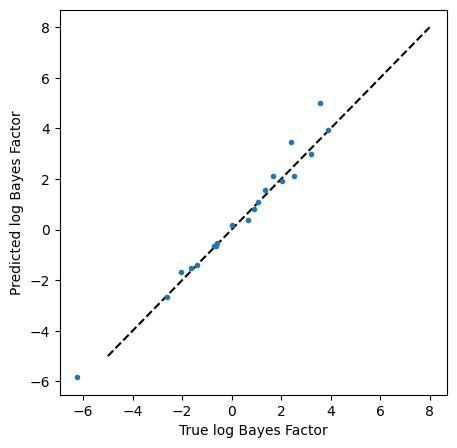

In [17]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
_x = np.linspace(-5,8,100)
ax.plot(_x, _x, 'k--')
ax.plot(-lnK_test, lnK_pred[:,0], '.')
ax.set(xlabel='True log Bayes Factor', ylabel='Predicted log Bayes Factor')

## Evidence Networks (Bayes Factor)

In [1]:
from ili.evidence import K_EvidenceNetwork

runner = K_EvidenceNetwork(
    layer_width=32, added_layers=2,
    batch_norm_flag=0, alpha=2,
    train_args=dict(
        max_epochs=200, lr=1e-6, 
        training_batch_size=128,
        stop_after_epochs=40,
        validation_fraction=0.1)
)

INFO:2025-04-27 00:59:14,132:jax._src.xla_bridge:925: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-27 00:59:14,134:jax._src.xla_bridge:925: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:
summary = runner.train(loader1_train, loader2_train)

NameError: name 'loader1_train' is not defined

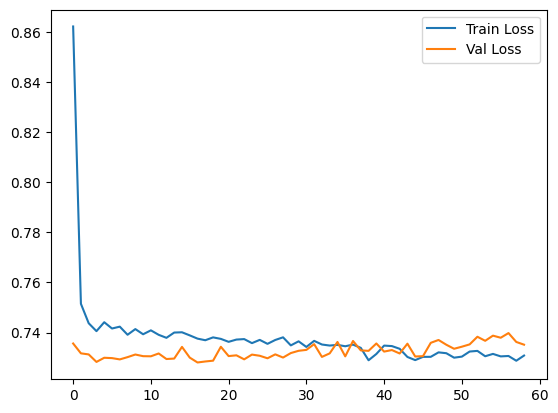

In [21]:
plt.plot(summary['training_loss'], label='Train Loss')
plt.plot(summary['validation_loss'], label='Val Loss')
# plt.ylim(0.99,1.01)
plt.legend()

In [22]:
logK = runner.predict(x_obs).detach().numpy()[0]
print(f'Predicted lnK: {logK[0]}')
print(f'True lnK: {-np.log(K_obs)}')

Predicted lnK: -0.9835840463638306
True lnK: -0.940139453176652


[Text(0.5, 0, 'True lnK'), Text(0, 0.5, 'Predicted lnK')]

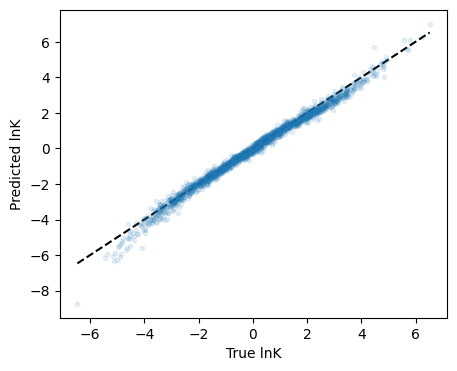

In [23]:
logK1_pred = runner.predict(x1_test).detach().numpy()
logK2_pred = runner.predict(x2_test).detach().numpy()
logK1_true = np.log(K1_test)
logK2_true = np.log(K2_test)

f, ax = plt.subplots(1, 1, figsize=(5, 4))
_x = np.linspace(logK1_true.min(), logK2_true.max(), 100)
ax.plot(_x, _x, '--', c='black')
ax.plot(logK1_true, logK1_pred, '.', c='C0', label='Model 1', alpha=0.1)
ax.plot(logK2_true, logK2_pred, '.', c='C0', label='Model 2', alpha=0.1)
ax.set(xlabel='True lnK', ylabel='Predicted lnK')